## Pipeline for generating and comparing templates

# Imports and helpers

In [566]:
#Imports
import numpy as np
from midiutil import MIDIFile
import matplotlib.pyplot as plt
import ternary
from ternary.helpers import simplex_iterator
import graphviz
import anytree as at
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
import theano.tensor as T
from theano import function
import theano

# helpers from my files
import sys
sys.path.insert(0, 'helpers/')
from tree_parser import TreeParser
from midi import *
from bidict import bidict

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

The constants for the rhythm. L is the length [in beats] of a rhythm, N is the number of levels in the tree, including level 0.

In [2]:
# CONSTANTS
L = 8 # length of measure
N = int(np.log2(L)+1) # Number of levels (including 0)

In [3]:
# Initial THEANO symbolic variables

p1 = T.dscalar('p1')
p2 = T.dscalar('p2')
p3 = T.dscalar('p3')

# Set of all trees, and probability of all trees

To generate the trees, we use a bottom-up dynamic programming paradigm, by first generating 1-level trees, then using them as building blocks for 2-levels trees, and so on, up to N. All the trees are of the form of recursive tuples, where the presence of a tuple means a p1 node, and the presence of p2 and p3 mean p2 or p3 terminals. All the trees are then stored inside a set of all trees callted **all_trees**.

In parallel, we do compute the probability of each tree by simply mutilplying the value of each root and node of the tree, and storing them as a Theano product symbolic carible. The product of the probabilities is as well done with the bottom-up fasion. Then we create a dictionary **tree2prob[tree]** where the key is a tree, and the value is a Theano symbolic probability.

In [6]:
#With direct computation of the probs (very slow)

# Templates level 1
templates_1 = set()
templates_1.add(p2)
templates_1.add(p3)

tree_prob_1 = dict()
tree_prob_1[p2] = p2
tree_prob_1[p3] = p3

# Templates level 2
templates_2 = set()
templates_2.add(p2)
templates_2.add(p3)

tree_prob_2 = dict()
tree_prob_2[p2] = p2
tree_prob_2[p3] = p3

for elem1 in templates_1:
    for elem2 in templates_1:
        templates_2.add((elem1, elem2))      
        tree_prob_2[(elem1, elem2)] = p1*tree_prob_1[elem1]*tree_prob_1[elem2]

# Templates level 3
templates_3 = set()
templates_3.add(p2)
templates_3.add(p3)

tree_prob_3 = dict()
tree_prob_3[p2] = p2
tree_prob_3[p3] = p3

for elem1 in templates_2:
    for elem2 in templates_2:
        templates_3.add((elem1, elem2))
        tree_prob_3[(elem1, elem2)] = p1*tree_prob_2[elem1]*tree_prob_2[elem2]
        
# Templates level 4
templates_4 = set()
templates_4.add(p2)
templates_4.add(p3)

tree_prob_4 = dict()
tree_prob_4[p2] = p2
tree_prob_4[p3] = p3

for elem1 in templates_3:
    for elem2 in templates_3:
        templates_4.add((elem1, elem2))
        tree_prob_4[(elem1, elem2)] = p1*tree_prob_3[elem1]*tree_prob_3[elem2]
        
# Templates level 5
all_trees = set()
all_trees.add(p2)
all_trees.add(p3)

tree2prob = dict()
tree2prob[p2] = p2
tree2prob[p3] = p3

for elem1 in templates_3:
    for elem2 in templates_3:
        all_trees.add((elem1, elem2))
        tree2prob[(elem1, elem2)] = p1*tree_prob_3[elem1]*tree_prob_3[elem2]
        
len(tree2prob)

1446

# Set of all rhythms

We generate all rhythms by simply converting all integers from 0 to 2^L into binary, and then store them as tuples of characters for each 0 and 1. All the rhythms of type tuple are then stored into a set called **all_rhythms**.

In [7]:
all_rhythms = set()

for i in range(2**L): # populating
    all_rhythms.add( tuple(("{0:0%sb}" %L).format(i)) )
    
len(all_rhythms)

256

# 2-way dictionnary between trees and rhythms

Each tree leads to 1 rhythm, but many trees can lead to the same rhythm. We use a data structure call bidict which, from a one way dictionary, generate the inverse dictionary automatically. 

We first generate a dictionary from tree to its one **rhythm tree2rhythm[tree]**, since its a one to one relation and easier to implement, and then after we'll let the bidict sutructure automatically generate the inverse dictionary from rhythm to tree **rhythm2trees[rhythm]**.

The **rhythm tree2rhythm[tree]** dictionary is created by generating the rhythm recursively by looking at the tree from the root and recursing over the 2 halves of the trees and so forth. Then the **rhythm2trees[rhythm]** is computed automatically by bidict, and is a dictionary from a rhythm to a list of trees.

In [8]:
def tree_to_rhythm(tree, size=L):    
    if(p2 == tree):
        tup = ('1',) + ('0',) * int(size-1)
        return tup    
    elif(p3 == tree):
        tup = ('0',) * int(size)
        return tup    
    else:
        return tree_to_rhythm(tree[0], size/2) + tree_to_rhythm(tree[1], size/2)
    
trees2rhythms = bidict() # initial bidirection dictionary (can't be stored with pickle.....)

for tree in all_trees:
    trees2rhythms[tree] = tree_to_rhythm(tree)
    
# 2 dict for the 2 directions 
rhythm2trees = trees2rhythms.inverse
tree2rhythm  = dict(trees2rhythms)

len(rhythm2trees)

256

# Probability of each rhythm (set)

In [570]:
rhythm2prob = {}

for rhythm in all_rhythms: 
    prob_rhythm = 0
    for tree in rhythm2trees[rhythm]:
        prob_rhythm += tree2prob[tree]
        
    rhythm2prob[rhythm] = prob_rhythm   

# Set of all templates, and probability of a template

In [36]:
# Templates level 1
templates_1 = set()
templates_1.add(p2)
templates_1.add(p3)
templates_1.add(tuple())

template_prob_1 = dict()
template_prob_1[p2] = p2
template_prob_1[p3] = p3
template_prob_1[tuple()] = p1

# Templates level 2
templates_2 = set()
templates_2.add(p2)
templates_2.add(p3)

template_prob_2 = dict()
template_prob_2[p2] = p2
template_prob_2[p3] = p3

for elem1 in templates_1:
    for elem2 in templates_1:
        templates_2.add((elem1, elem2))
        template_prob_2[(elem1, elem2)] = p1*template_prob_1[elem1]*template_prob_1[elem2]
        
# Templates level 3
all_templates = set()
all_templates.add(p2)
all_templates.add(p3)

template2prob = dict()
template2prob[p2] = p2
template2prob[p3] = p3

for elem1 in templates_2:
    for elem2 in templates_2:
        all_templates.add((elem1, elem2))
        template2prob[(elem1, elem2)] = p1*template_prob_2[elem1]*template_prob_2[elem2]
               
len(template2prob)

123

# 2-ways dict between templates and trees

In [11]:
def tree_to_template(tree, depth=0):
    if isinstance(tree, tuple) and depth<2:
        return (tree_to_template(tree[0], depth+1), tree_to_template(tree[1], depth+1))
    
    if isinstance(tree, tuple):
        return tuple()
    
    return tree

trees2templates = bidict() # initial bidirection dictionary (can't be stored with pickle.....)

for tree in all_trees:
    trees2templates[tree] = tree_to_template(tree)
    
# 2 dict for the 2 directions 
template2trees = trees2templates.inverse
tree2template  = dict(trees2templates)

# 2-ways dict betweem rhythms and templates

In [12]:
rhythm2templates = dict()

for rhythm in all_rhythms:
    temp_set = set()
    for tree in rhythm2trees[rhythm]:
        temp_set.add(tree2template[tree])
        
    rhythm2templates[rhythm] = temp_set

#-----------------------

template2rhythms = dict()

for template in all_templates:
    rhythm_set = set()
    for tree in template2trees[template]:
        rhythm_set.add(tree2rhythm[tree])
        
    template2rhythms[template] = rhythm_set
    
len(template2rhythms)

123

# Prob of a rhythm knowing its template

In [58]:
rhythm_template2prob = dict()

for template in all_templates:
    temp_prob = template2prob[template]
    for rhythm in template2rhythms[template]:
        connection_trees_prob=0
        for tree in template2trees[template]:
            if (tree in rhythm2trees[rhythm]):
                connection_trees_prob += tree2prob[tree]
                
        rhythm_template2prob[(rhythm, template)] = connection_trees_prob / temp_prob
              
len(rhythm_template2prob)

1446

# Dict template to its entropy

In [466]:
from theano.ifelse import ifelse

zero = T.dscalar('zero') # Stupid zero value to replace infinite logarithms with zero

template2entropy = dict()

for template in all_templates:
    all_probs=list()
    if(not template2rhythms[template]):
        print(f"Warning! No rhythm was assigned to the template {template}")
    for rhythm in template2rhythms[template]:
        modified_log = ifelse(T.isinf(T.log2(rhythm2prob[rhythm])), zero, T.log2(rhythm2prob[rhythm]) ) # Avoid NaNs by replacing them with zeros        
        all_probs.append(modified_log*rhythm2prob[rhythm])
        
    template2entropy[template] = T.sum(all_probs, axis=0)
            
len(template2entropy)

123

In [478]:
# 'template2entropy_f' : Dictionnary of templates to their actual Python functions
from theano import In
template2entropy_f = dict()
for template in all_templates:
    template2entropy_f[template] = theano.function([p1, p2, p3, In(zero, value=1)], template2entropy[template], on_unused_input='ignore')
    
len(template2entropy_f)

123

# Dict template to its ENB

In [370]:
# Weigths for the ENB
weights = (1,) * L

def rhythm_to_NB(rhythm):
    NB = 0
    for i in range (len(rhythm)):
        if(rhythm[i]=='1'):
            NB+=weights[i]       
    return NB

template2ENB = dict()

# 'template2ENB' : Dictionnary of templates to their symbolic ENB function
for template in all_templates:
    ENB = 0
    for rhythm in template2rhythms[template]:
        ENB += rhythm_to_NB(rhythm) * rhythm_template2prob[(rhythm, template)]
        
    template2ENB[template] = ENB
    
len(template2ENB)

123

In [583]:
# 'template2ENB_f' : Dictionnary of templates to their actual Python functions
template2ENB_f = dict()
for template in all_templates:
    template2ENB_f[template] = theano.function([p1, p2, p3], template2ENB[template], on_unused_input='ignore')
    
len(template2ENB_f)

123

# Visalization of loss function

In [613]:
template2=((p3, p2), (p2, ()))
template1= (((), ()), ((), p3))

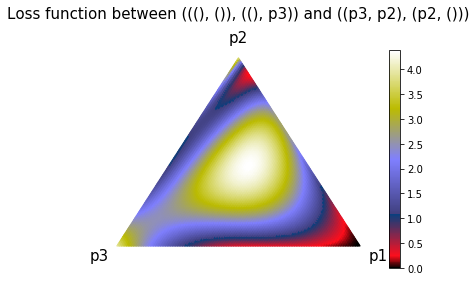

In [603]:
#Graph for the loss function
import ternary
from ternary.helpers import simplex_iterator
scale = 100
def generate_heatmap_data(scale=scale):
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = cost_f([i/scale,j/scale,k/scale])
    return d

data = generate_heatmap_data(scale)
figure, tax = ternary.figure(scale=scale)
tax.heatmap(data, style="triangular", cmap=plt.cm.gist_stern)
#tax.boundary()
fontsize = 15
tax.set_title(f"Loss function between {template1} and {template2}", fontsize=fontsize,y=1.12)
tax.left_corner_label("p3", fontsize=fontsize)
tax.right_corner_label("p1", fontsize=fontsize)
tax.top_corner_label("p2", fontsize=fontsize)
plt.axis('off')
plt.savefig(f"graphs/loss/loss_{template1}_{template2}", dpi=400, bbox_inches='tight')
plt.plot()
plt.show()

# Minimization loss loop over all templates pairs

In [608]:
from scipy.optimize import minimize
bnds = ((0, .99), (0, 1), (0, 1)) # variable bounds (.99 for p1 to avoid div by zero)
x0 = np.array([1/3, 1/3, 1/3]) # initial vector

def con(a): # function for constraint (probs sum up to 1)
    return a[0]+a[1]+a[2]-1
cons = {'type':'eq', 'fun': con}

template_pairs = dict() # dict of all template pairs with their p1 p2 p3 optimal values

iterator = 0

used_templates = set()
for template1 in all_templates:
    
    iterator+=1
    print(f"{iterator}  : {template1}")
    
    used_templates.add(template1)
    for template2 in all_templates:
        if(template2 not in used_templates):
            
            # templates have to be set as global variables (since they're not to be minimized)
            def cost_f(p):
                p1=p[0]
                p2=p[1]
                p3=p[2]
                return ( (template2entropy_f[template1](p1, p2, p3) - template2entropy_f[template2](p1, p2, p3))**2
                        + (template2ENB_f[template1](p1, p2, p3) - template2ENB_f[template2](p1, p2, p3))**2
                        + (p1+p2+p3-1)**2 )

            template_pairs[(template1, template2)] = minimize(cost_f, x0, bounds=bnds, constraints=cons)
            template_pairs[(template2, template1)] = template_pairs[(template1, template2)] # add symmetry

1  : (p3, p3)
2  : (p2, p3)
3  : (p2, ((), p3))
4  : ((p3, p2), p2)
5  : (((), p3), p2)
6  : (((), p3), ((), p2))
7  : ((p2, ()), (p2, p2))
8  : ((p3, p2), (p3, ()))
9  : ((p3, ()), (p2, p3))
10  : ((p2, p2), ((), p3))
11  : ((p3, p3), (p3, p3))
12  : (((), p3), (p3, ()))
13  : (((), ()), ((), ()))
14  : ((p2, p3), (p2, p2))
15  : ((p3, p2), ((), p2))
16  : ((p2, p2), p3)
17  : (p2, ((), p2))
18  : (((), p2), ((), ()))
19  : ((p3, p3), ((), p2))
20  : (((), ()), (p2, p3))
21  : ((p3, p2), (p3, p3))
22  : ((p2, ()), (p2, ()))
23  : ((p3, p2), (p3, p2))
24  : ((p2, p3), (p2, ()))
25  : ((p2, p2), ((), ()))
26  : ((p3, p3), (p2, p2))
27  : (((), ()), ((), p3))
28  : (p2, (p3, p2))
29  : ((p3, p3), (p3, p2))
30  : ((p2, p2), (p3, p2))
31  : ((p3, ()), (p2, ()))
32  : (p2, (p3, p3))
33  : (((), p2), (p2, p3))
34  : ((p3, p2), p3)
35  : (p2, (p3, ()))
36  : ((p2, p2), p2)
37  : ((p2, p2), ((), p2))
38  : ((p3, p2), ((), p3))
39  : ((p2, p2), (p3, ()))
40  : (((), p3), ((), p3))
41  : ((p2, (

In [615]:
template_pairs

{((p3, p3),
  (p2,
   p3)):      fun: 1.0
     jac: array([1.49011612e-08, 1.49011612e-08, 1.49011612e-08])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.33333333, 0.33333333, 0.33333333]),
 ((p2, p3),
  (p3,
   p3)):      fun: 1.0
     jac: array([1.49011612e-08, 1.49011612e-08, 1.49011612e-08])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.33333333, 0.33333333, 0.33333333]),
 ((p3, p3),
  (p2,
   ((),
    p3))):      fun: 1.1590345886192731e-06
     jac: array([-4.01118896e-07, -1.17543337e-03,  1.48844232e-03])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.97679858, 0.01141998, 0.01178144]),
 ((p2, ((), p3)),
  (p3,
   p3)):      fun: 1.1590345886192731e-06
     jac: array([-4.01118896e-07, -1.17543337e-03,  1.48844232e-03])
 me